# Sampling functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

# Complete the implementations of
- UnivariateNormal
- MultivariateNormal
- Categorical
- MixtureModel

In [3]:
class ProbabilityModel:

    # Returns a single sample (independent of values returned on previous calls).
    # The returned value is an element of the model's sample space.
    def sample(self):
        return np.random.uniform()


# The sample space of UnivariateNormal is the set of real numbers, and
# the probability measure is defined by the density function
# p(x) = 1/(sigma * (2*pi)^(1/2)) * exp(-(x-mu)^2/2*sigma^2)

class UnivariateNormal(ProbabilityModel):
    # Initializes a univariate normal probability model object
    # parameterized by mu and (a positive) sigma
    def __init__(self,mu,sigma):
        self.mu = mu
        if sigma >= 0:
          self.sigma = sigma
        else:
          print("Negative sigma entered. Taking absolute value.")
          self.sigma = -1*sigma

    def sample(self, size=1000):
      '''Using Box-Mueller Implementation
      '''
      u1 = np.random.default_rng().uniform(size=size)
      u2 = np.random.default_rng().uniform(size=size)
      # Standard Normal pair
      Z0 = np.sqrt(-2*np.log(u1))*np.cos(2*np.pi*u2)
      #Z1 = np.sqrt(-2*np.log(u1))*np.sin(2*np.pi*u2)
      # Scaling
      Z0 = Z0*self.sigma + self.mu

      # Alternate implementation:
      # return np.random.default_rng().normal(self.mu, self.sigma, size)

      return Z0



# The sample space of MultiVariateNormal is the set of D dimensional real
# column vectors (modeled as numpy.array of size D x 1), and the probability
# measure is defined by the density function
# p(x) = 1/(det(Sigma)^(1/2) * (2*pi)^(D/2)) * exp( -(1/2) * (x-mu)^T * Sigma^-1 * (x-mu) )

class MultiVariateNormal(ProbabilityModel):

    # Initializes a multivariate normal probability model object
    # parameterized by Mu (numpy.array of size D x 1) expectation vector
    # and symmetric positive definite covariance Sigma (numpy.array of size D x D)
    def __init__(self,Mu,Sigma):
        self.dim = np.shape(Mu)[0]
        self.Mu = np.array(Mu).reshape(self.dim, 1)
        self.Sigma = np.array(Sigma)


    def sample(self, size):
        # Step 1: Compute the Cholesky Decomposition
        # Define epsilon.
        epsilon = 0.0001

        # Add small pertturbation.
        K = self.Sigma + epsilon*np.identity(self.dim)
        #  Cholesky decomposition.
        L = np.linalg.cholesky(K)

        # Step 2: Generate Independent Samples u
        u = np.random.default_rng().normal(size=self.dim*size).reshape(self.dim, size)

        # Step 3: Compute samples
        samples = self.Mu + np.dot(L, u)

        return samples

# The sample space of the Categorical model is the finite discrete set {0..k-1}, and
# the probability measure is defined by the atomic probabilities
# P(i) = ap[i]

class Categorical(ProbabilityModel):

    # Initializes a categorical (a.k.a. multinom, multinoulli, finite discrete)
    # probability model object with distribution parameterized by the atomic probabilities vector
    # ap (numpy.array of size k).
    def __init__(self,ap):
        '''
        Categorical(ap)
        ap: atomic probabilities vector (numpy.array of fixed size k)
        '''
        self.ap = ap
        self.k = len(ap) # no. of categories

    def sample(self, size):
        cumsum_ap = np.cumsum(self.ap)
        dataset_x = np.random.default_rng().uniform(size=size)
        range_list = [dataset_x <= sum for sum in cumsum_ap]
        catg_matrix = [i * np.ones(size) for i in range(self.k)]
        samples = np.select(condlist=range_list, choicelist=catg_matrix)
        return samples


# The sample space of the Mixture model is the union of the sample spaces of
# the underlying probability models, and the probability measure is defined by
# the atomic probability vector and the densities of the supplied probability models
# p(x) = sum ap[i] p_i(x)

class MixtureModel(ProbabilityModel):

    # Initializes a mixture-model object parameterized by the
    # atomic probabilities vector ap (numpy.array of size k) and by the tuple of
    # probability models pm
    def __init__(self,ap,pm):
        self.ap = ap
        self.pm = pm
        self.k = len(self.ap)

    def sample(self, size):
        samples = []
        for i in range(self.k):
          multi_norm_model = MultiVariateNormal(Mu=pm[i]["Mu"], Sigma=pm[i]["Sigma"])
          multi_norm_samples = multi_norm_model.sample(int(size/self.k))
          samples.append(multi_norm_samples)
        return samples



# Test your samplers
- once you complete the functions above, run each box below and keep the resulting plot in the notebook that you upload on Gradescope.

## Categorical test
- generate 10,000 samples by a categorical distribution with probabilities [0.1,0.1,0.3,0.3,0.2]
- plot a histogram of the samples using plt.hist (bins=10)

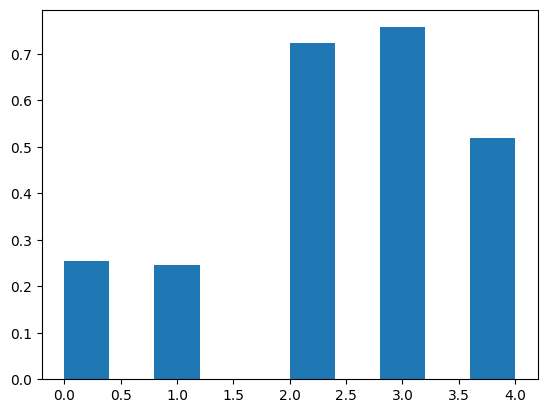

In [ ]:
# generate 10,000 samples by a categorical distribution with probabilities [0.1,0.1,0.3,0.3,0.2]
size = 10000
ap = [0.1, 0.1, 0.3, 0.3, 0.2]
catg_model = Categorical(ap)
catg_samples = catg_model.sample(size=10000)

# plot a histogram of the samples using plt.hist (bins=10)
n_bins = 10
count, bins, ignored = plt.hist(catg_samples, bins=n_bins, density=True)

## UnivariateNormal test
- generate 10,000 samples from the distribution with mean = 0, std = 1
- print the mean and std of the samples using np.mean and np.std
- plot a histogram of the samples using plt.hist with bins=100

Mean:	0.004776748718131283
Standard Deviation:	1.0009867235510075


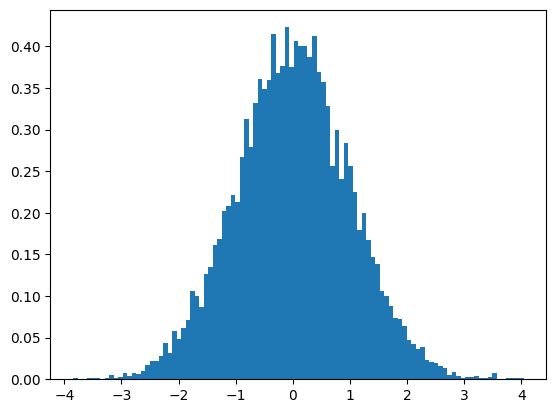

In [ ]:
# generate 10,000 samples from the distribution with mean = 0, std = 1
mu, sigma = 0, 1 # mean and std
uni_norm_model = UnivariateNormal(mu, sigma)
uni_norm_samples = uni_norm_model.sample(10000)

# print the mean and std of the samples using np.mean and np.std
print("Mean:\t" + str(np.mean(uni_norm_samples)))
print("Standard Deviation:\t" + str(np.std(uni_norm_samples)))

# plot a histogram of the samples using plt.hist with bins=100
n_bins = 100

count, bins, ignored = plt.hist(uni_norm_samples, bins=n_bins, density=True)

## MultivariateNormal test
- generate 10,000 samples for a 2-D Gaussian with mean at [1,1] and a covariance matrix [[1,0.5],[0.5,1]]
- print the mean and covariance of the samples using np.mean and np.cov
- produce a scatterplot of the 2-D samples using plt.scatter

Mean: 0.9962927386859954
Covariance: 
[[0.99383608 0.50595968]
 [0.50595968 0.99171615]]


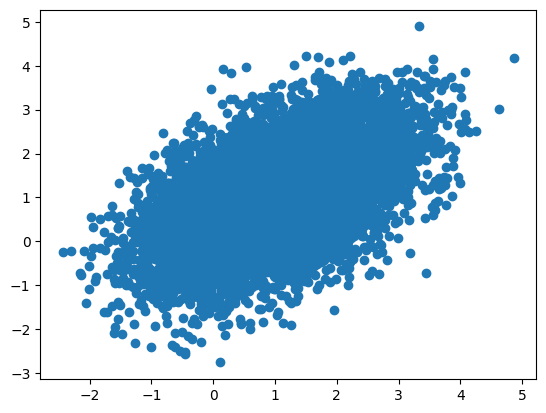

In [ ]:
# generate 10,000 samples for a 2-D Gaussian with mean at [1,1] and a covariance matrix [[1,0.5],[0.5,1]]
multi_norm_model = MultiVariateNormal(Mu=[1, 1], Sigma=[[1, 0.5], [0.5, 1]])
multi_norm_samples = multi_norm_model.sample(10000)

# print the mean and covariance of the samples using np.mean and np.cov
print("Mean: " + str(np.mean(multi_norm_samples)))
print("Covariance: \n" + str(np.cov(multi_norm_samples)))

# produce a scatterplot of the 2-D samples using plt.scatter
plt.scatter(multi_norm_samples[0], multi_norm_samples[1])

## MixtureModel test
- Construct a mixture model consisting of an equal-weighted mixture of four Gaussians in 2 dimensions, centered at (2,2), (2,-2), (-2,2) and (-2,-2),  and having covariance $$I$$
- generate 100,000 samples from this mixture
- generate a scatter plot of samples using plt.scatter
- What is the probability that a point in this sample lies within a unit circle centered at (1,1)?  Print that probabillity.

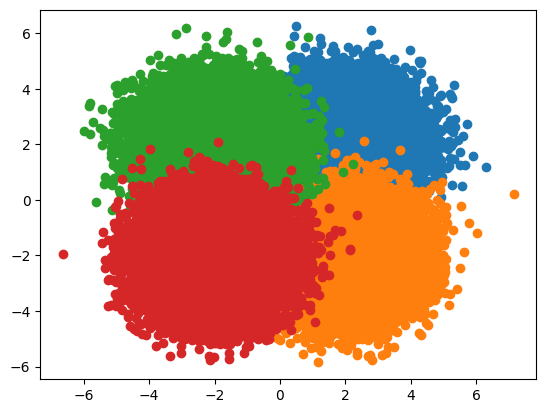

In [9]:
# Construct a mixture model consisting of an equal-weighted mixture of four Gaussians in 2 dimensions, centered at (2,2), (2,-2), (-2,2) and (-2,-2), and having covariance 𝐼
I = np.identity(2)
pm= [
    {
        "Mu": [2,2],
        "Sigma": I
    }, {
        "Mu": [2,-2],
        "Sigma": I
    }, {
        "Mu": [-2,2],
        "Sigma": I
    }, {
        "Mu": [-2,-2],
        "Sigma": I
    }
  ]
ap = [0.25, 0.25, 0.25, 0.25]
mix_model = MixtureModel(ap=ap, pm=pm)

# generate 100,000 samples from this mixture
mix_model_samples = mix_model.sample(100000)

# generate a scatter plot of samples using plt.scatter
for sample in mix_model_samples:
  plt.scatter(sample[0], sample[1])


References:
   1. Sampling functions for Univariate Normal & Categorical distributions were implemented by referring to the implementations here:
   https://github.com/tirthajyoti/Stats-Maths-with-Python/blob/master/Generating-random-variables-from-scratch.ipynb
   2. Multivariate Normal Sampling Implementation Reference: https://juanitorduz.github.io/multivariate_normal/
   3. Categorical Sampling Algorithm referenced from: [Sampling the Categorical Distribution | Intuition & using NumPy](https://youtu.be/MYHxW-MIld0?feature=shared)
